# download model

In [1]:
#!rm -rf /content/extracted_files

# unzipping the dataset

## Step 1: Check if CUDA is available

In [ ]:
import torch
import torch.nn as nn
import os

# Define the model path
model_path = 'D:\PhD\china research conference\checkpoint-best.pth'  # correct path

torch.backends.cudnn.benchmark = True


## Step 2: Inspect the .pth File
This step checks whether the file contains a full model or just weights.

In [3]:
#Load the model checkpoint
model_path = 'checkpoint-best.pth'
checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)

#Check if it contains a full model or just weights
if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
    print('The .pth file contains only state_dict (weights).')
    print('Available keys:', checkpoint.keys())
else:
    print('The .pth file may contain a full model.')
    print(type(checkpoint))  # Print type to confirm

#If state_dict exists, print the layer names (keys)
if isinstance(checkpoint, dict):
    print('\nModel State Dict Keys (Layer Names):')
    print(checkpoint['state_dict'].keys() if 'state_dict' in checkpoint else checkpoint.keys())

#Print first 10 keys to check structure
print("\nFirst 10 layer names in checkpoint:")
print(list(checkpoint['model'].keys())[:10]) 


The .pth file may contain a full model.
<class 'dict'>

Model State Dict Keys (Layer Names):
dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'args'])

First 10 layer names in checkpoint:
['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias']


## Step 2: Select & Load the correct Pretrained Model
If the .pth file only contains weights, we load a pretrained model like ViT and fit those weights in it.

In [4]:
import torch
import timm
import torch.nn as nn

#Load checkpoint with weights_only=False (Trusted Source)
model_path = "checkpoint-best.pth"  # Update with the actual path
checkpoint = torch.load(model_path, map_location="cpu", weights_only=False)  # Allow full deserialization

#Extract the first few layers to determine the model type
first_layers = list(checkpoint['model'].keys())[:10]
print(f"\nFirst 10 layer names in checkpoint:\n{first_layers}")

#Check hidden size from 'cls_token' to determine the model variant
hidden_size = checkpoint['model']['cls_token'].shape[-1]
print(f"\nDetected hidden size from checkpoint: {hidden_size}")

#Automatically determine which ViT model to use
if hidden_size == 768:
    model_name = 'vit_base_patch16_224'
elif hidden_size == 1024:
    model_name = 'vit_large_patch16_224'
elif hidden_size == 1280:
    model_name = 'vit_huge_patch14_224'
else:
    raise ValueError(f"Unknown hidden size {hidden_size}. This may not be a Vision Transformer.")

print(f"\n Loading the suitable pretrained model: {model_name}")

#Load the corresponding model (without downloading pretrained weights to save time)
model = timm.create_model(model_name, pretrained=False)

#Modify the classifier head for 7-class classification and introducing dropout
num_features = model.head.in_features
model.head = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout added before final layer
    nn.Linear(num_features, 7)
)
#num_features = model.head.in_features
#model.head = torch.nn.Linear(num_features, 7)

# Load the checkpoint weights (handling "module." prefix if needed)
loaded_weights = {k.replace("module.", ""): v for k, v in checkpoint['model'].items()}

#Load weights into model with error handling
missing_keys, unexpected_keys = model.load_state_dict(loaded_weights, strict=False)
print(f"\n Model successfully loaded with {len(missing_keys)} missing keys and {len(unexpected_keys)} unexpected keys.")

#Move to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"\n Model successfully moved to {device} and ready for fine-tuning!")



First 10 layer names in checkpoint:
['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias']

Detected hidden size from checkpoint: 1024

 Loading the suitable pretrained model: vit_large_patch16_224

 Model successfully loaded with 4 missing keys and 4 unexpected keys.

 Model successfully moved to cuda and ready for fine-tuning!


## step #: Check which layers were not loaded correctly

In [5]:
#Print missing and unexpected keys
print("\nMissing Keys (Layers that were expected but not found in checkpoint):")
print(missing_keys if missing_keys else " No missing keys!")

print("\nUnexpected Keys (Layers that were found in checkpoint but not in the model):")
print(unexpected_keys if unexpected_keys else " No unexpected keys!")



Missing Keys (Layers that were expected but not found in checkpoint):
['norm.weight', 'norm.bias', 'head.1.weight', 'head.1.bias']

Unexpected Keys (Layers that were found in checkpoint but not in the model):
['fc_norm.weight', 'fc_norm.bias', 'head.weight', 'head.bias']


## step #: Manually initializing missing layers

In [6]:
with torch.no_grad():
    model.norm.weight.fill_(1.0)
    model.norm.bias.zero_()
print(" Initialized missing normalization layers.")


 Initialized missing normalization layers.


## step #: Check if weights are correctly loaded
Compare pretrained ResNet weights vs. loaded weights:

In [7]:
#Extract pretrained weights for comparison
pretrained_weights = timm.create_model("vit_large_patch16_224", pretrained=True).state_dict()

#Choose a key from your checkpoint (adjust as needed)
layer_name = "blocks.0.attn.qkv.weight"  # This layer exists in both models

if layer_name in checkpoint['model']:
    loaded_weight = checkpoint['model'][layer_name]
    pretrained_weight = pretrained_weights[layer_name]

    print(f"Checking weights for layer: {layer_name}")
    print(" Loaded Weights Mean:", torch.mean(loaded_weight))
    print(" Pretrained Weights Mean:", torch.mean(pretrained_weight))

    #Optionally check if they are very different
    weight_diff = torch.abs(loaded_weight - pretrained_weight).mean()
    print(f"Mean Absolute Difference: {weight_diff:.6f}")

else:
    print(f"Layer '{layer_name}' not found in the loaded weights!")


Checking weights for layer: blocks.0.attn.qkv.weight
 Loaded Weights Mean: tensor(-1.8777e-05)
 Pretrained Weights Mean: tensor(-1.5380e-05)
Mean Absolute Difference: 0.020121


## Step 3: Verify the Last Fully Connected (FC) Layer
Since we modified the fc layer:

In [8]:
model.fc = torch.nn.Linear(num_features, 7)
print("FC Layer Weights:", model.fc.weight.shape)
print("FC Layer Bias:", model.fc.bias.shape)


FC Layer Weights: torch.Size([7, 1024])
FC Layer Bias: torch.Size([7])


## Step 3: Verify If GPU is Used Correctly
If you're using CUDA, confirm that the model and weights are on GPU:

## Step 3: Visualize Model Architecture & Features
This step prints the model structure and the number of features.

In [9]:
#Print model architecture
print(model)

#Extract feature details
num_inputs, num_outputs = None, None
layer_info = []

for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Linear):
        layer_info.append((name, layer.in_features, layer.out_features))
        if num_inputs is None:
            num_inputs = layer.in_features
        num_outputs = layer.out_features

print(f'Number of Input Features: {num_inputs}')
print(f'Number of Output Features: {num_outputs}')
print('\nLayer-wise Features:')
for layer in layer_info:
    print(f'Layer: {layer[0]}, Input Features: {layer[1]}, Output Features: {layer[2]}')

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

## Step 4: Prepare Dataset for Fine-Tuning
Load images, apply transformations, and prepare DataLoader.

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Standard ImageNet mean & std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

#Training Transform (More Diverse Augmentation)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    #transforms.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    #transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    #transforms.RandomErasing(p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random')
])

#Validation & Test Transform
transform_val_test = transforms.Compose([
    transforms.Resize(224),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

#Dataset paths
train_path = "extracted_files/train/"
val_path = "extracted_files/val/"
test_path = "extracted_files/test/"

#Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform_val_test)

#Create DataLoaders
batch_size = 8
#num_workers = 4
import os
num_workers = os.cpu_count() // 2  # try full CPU parallelism

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")


Training samples: 22965
Validation samples: 5744
Testing samples: 7178


## Step 5: Define optimiser and loss function

In [11]:
%pip install transformers
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from transformers import get_cosine_schedule_with_warmup

#Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Clear GPU memory
torch.cuda.empty_cache()

#Reduce batch size to avoid OOM
num_workers = os.cpu_count() // 2  # try full CPU parallelism
temp_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#Extract all labels
all_labels = []
for _, labels in temp_loader:
    all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)

#Compute class weights
num_classes = len(np.unique(all_labels))
class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(num_classes), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

#Define loss function (we’ll move it to GPU next)
criterion = nn.CrossEntropyLoss(weight=class_weights)

#Move model & criterion to GPU
try:
    model.to(device)
    criterion = criterion.to(device)
except RuntimeError:
    print("Model too large for GPU. Trying staged move...")
    for param in model.parameters():
        param.data = param.data.to(device)

#Define optimizer and LR scheduler
optimizer = optim.AdamW(model.parameters(), lr=7e-5, weight_decay=1e-11)
#this changes LR rapidly
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=4, verbose=True)

#this changes LR smoothly using cosine method
num_epochs = 10
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * total_steps)  #10% warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f" Model and loss function moved to {device}")
print(f" Class weights: {class_weights}")
print(f" Number of classes: {num_classes}")



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
 Model and loss function moved to cuda
 Class weights: tensor([1.0265, 9.4273, 1.0011, 0.5684, 0.8260, 0.8490, 1.2937])
 Number of classes: 7


In [12]:
#learning rate finder

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.70E-03


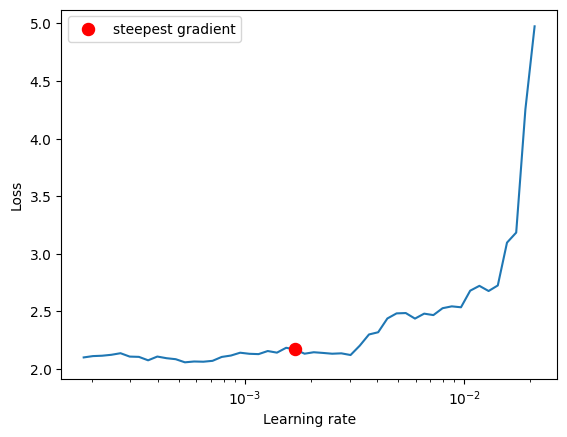

In [13]:
%pip install torch_lr_finder
from torch_lr_finder import LRFinder

# Step 1: Clone the model and move it to device
temp_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=7)
temp_model = temp_model.to(device)

# Step 2: Define a fresh optimizer (NO scheduler)
temp_optimizer = torch.optim.Adam(temp_model.parameters(), lr=7e-5)

# Step 3: Define the same loss function
temp_criterion = torch.nn.CrossEntropyLoss()

# Step 4: Run LR Finder
lr_finder = LRFinder(temp_model, temp_optimizer, temp_criterion, device=device)
lr_finder.range_test(train_loader, end_lr=1, num_iter=100)  # or more

# Step 5: Plot and pick LR
lr_finder.plot()
lr_finder.reset()


# cleaning the GPU memory

In [14]:
import gc  # Garbage collector
torch.cuda.empty_cache()
gc.collect()


10865

## Step 5: Train the Model
Fine-tune the model on your dataset.

In [15]:
import torch
from tqdm import tqdm

# Training parameters
num_epochs = 10  # Increased for fine-tuning
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience_counter = 0
patience = 6  # Early stopping patience

print(f"Using device: {device}")
print(f"Model is on: {next(model.parameters()).device}")
model = model.to(device)
print(f"Using device: {device}")
print(f"Model is on: {next(model.parameters()).device}")

# Correct AMP initialization
scaler = torch.amp.GradScaler(device='cuda')

print(f"Starting Training for {num_epochs} epochs on {device}!")

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()

        # AMP autocast context
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f" Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    current_lr = scheduler.get_last_lr()[0]
    print(f"Learning Rate: {current_lr:.8f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

print("Training Completed!")


Using device: cuda
Model is on: cuda:0
Using device: cuda
Model is on: cuda:0
Starting Training for 10 epochs on cuda!


Training Epoch 1/10:   0%|          | 0/2871 [00:00<?, ?it/s]c:\Users\samee\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Validating Epoch 1/10: 100%|██████████| 718/718 [01:49<00:00,  6.54it/s] 


 Epoch 1 - Train Loss: 1.8396 | Train Acc: 29.86% | Val Loss: 1.3584 | Val Acc: 48.00%
Learning Rate: 0.00007000


Validating Epoch 2/10: 100%|██████████| 718/718 [00:59<00:00, 12.12it/s]


 Epoch 2 - Train Loss: 1.3846 | Train Acc: 49.12% | Val Loss: 1.1781 | Val Acc: 55.00%
Learning Rate: 0.00006789


Validating Epoch 3/10: 100%|██████████| 718/718 [00:59<00:00, 12.09it/s]


 Epoch 3 - Train Loss: 1.2159 | Train Acc: 55.56% | Val Loss: 1.1017 | Val Acc: 58.58%
Learning Rate: 0.00006181


Validating Epoch 4/10: 100%|██████████| 718/718 [00:59<00:00, 12.15it/s]


 Epoch 4 - Train Loss: 1.1037 | Train Acc: 59.84% | Val Loss: 1.0188 | Val Acc: 61.98%
Learning Rate: 0.00005250


Validating Epoch 5/10: 100%|██████████| 718/718 [00:59<00:00, 12.16it/s]


 Epoch 5 - Train Loss: 0.9900 | Train Acc: 63.42% | Val Loss: 0.9664 | Val Acc: 64.40%
Learning Rate: 0.00004108


Validating Epoch 6/10: 100%|██████████| 718/718 [01:00<00:00, 11.90it/s]


 Epoch 6 - Train Loss: 0.8761 | Train Acc: 67.22% | Val Loss: 0.9506 | Val Acc: 64.73%
Learning Rate: 0.00002892


Validating Epoch 7/10: 100%|██████████| 718/718 [01:00<00:00, 11.87it/s]


 Epoch 7 - Train Loss: 0.7601 | Train Acc: 71.71% | Val Loss: 0.9177 | Val Acc: 66.82%
Learning Rate: 0.00001750


Validating Epoch 8/10: 100%|██████████| 718/718 [01:02<00:00, 11.54it/s]


 Epoch 8 - Train Loss: 0.6523 | Train Acc: 75.26% | Val Loss: 0.9245 | Val Acc: 67.84%
Learning Rate: 0.00000819


Validating Epoch 9/10: 100%|██████████| 718/718 [01:00<00:00, 11.79it/s]


 Epoch 9 - Train Loss: 0.5635 | Train Acc: 78.72% | Val Loss: 0.9481 | Val Acc: 67.58%
Learning Rate: 0.00000211


Validating Epoch 10/10: 100%|██████████| 718/718 [03:07<00:00,  3.82it/s]


 Epoch 10 - Train Loss: 0.5207 | Train Acc: 80.42% | Val Loss: 0.9541 | Val Acc: 67.91%
Learning Rate: 0.00000000
Training Completed!


# plot accuracy and loss graphs

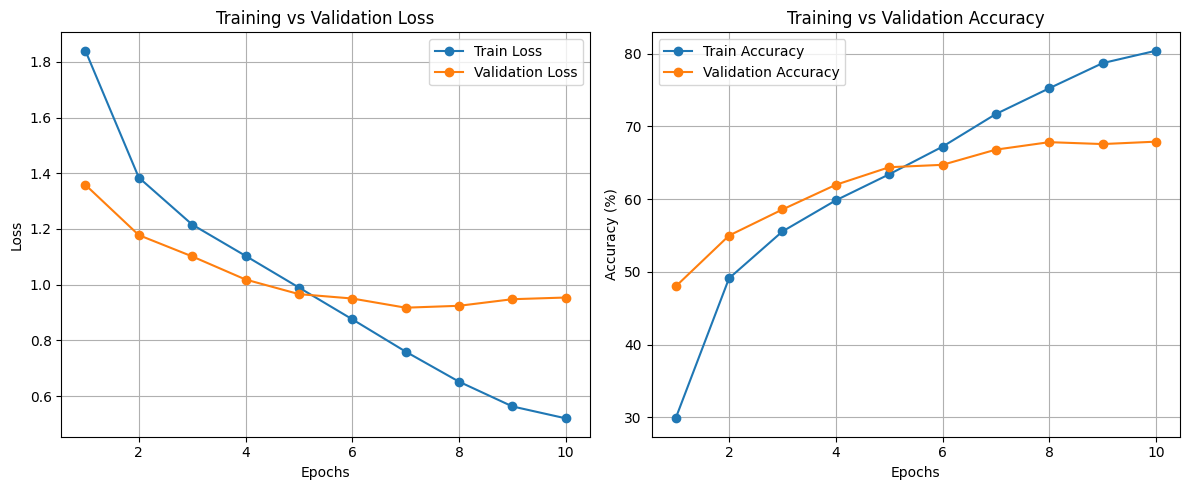

In [16]:
import matplotlib.pyplot as plt

epochs_ran = len(train_losses)  

plt.figure(figsize=(12, 5))

# 🔹 Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_ran + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, epochs_ran + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# 🔹 Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_ran + 1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, epochs_ran + 1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## model evaluation

C:\Users\samee\AppData\Local\Temp\ipykernel_33616\4222536459.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


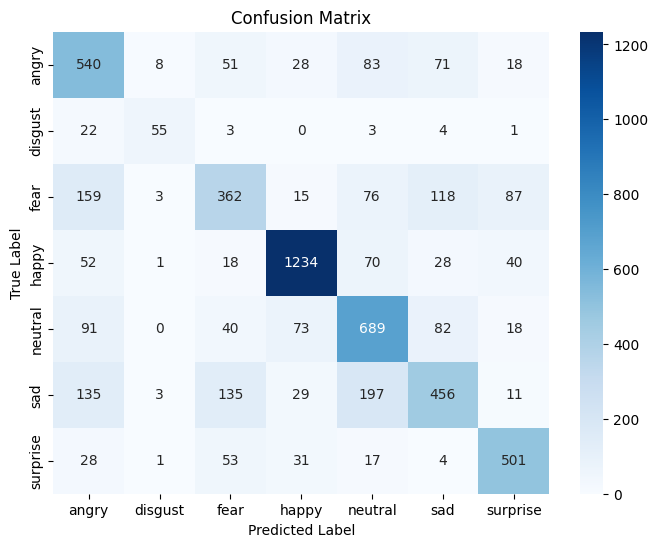


Classification Report:
               precision    recall  f1-score   support

       angry       0.53      0.68      0.59       799
     disgust       0.77      0.62      0.69        88
        fear       0.55      0.44      0.49       820
       happy       0.88      0.86      0.87      1443
     neutral       0.61      0.69      0.65       993
         sad       0.60      0.47      0.53       966
    surprise       0.74      0.79      0.76       635

    accuracy                           0.67      5744
   macro avg       0.67      0.65      0.65      5744
weighted avg       0.67      0.67      0.67      5744

 AUROC Score (weighted ovo): 0.9167


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import torch.nn.functional as F
import numpy as np

#Automatically get class names
class_names = val_dataset.classes
num_classes = len(class_names)

#Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)  #  Convert to probabilities
        _, predicted = torch.max(probs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)

#Compute AUROC using true labels and predicted probabilities
try:
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovo', average='weighted')
    print(f" AUROC Score (weighted ovo): {auroc:.4f}")
except Exception as e:
    print(f"Could not compute AUROC: {e}")


## Step 5: Evaluate on test data


 Final Test Accuracy: 0.6683


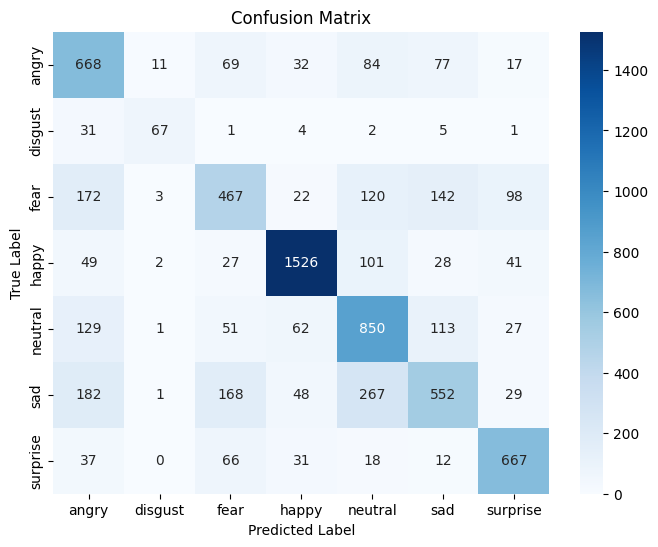

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

#Run inference on test set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Compute Accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n Final Test Accuracy: {test_accuracy:.4f}")

#Compute Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

#Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Step 5: Saving the fine tuned model

# Compute Sensitivity, Specificity, Accuracy, AUROC, and F1 Score

In [19]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report

model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Store all class probabilities

#Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

#Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
TP = np.diag(cm)  # True Positives for each class
FP = cm.sum(axis=0) - TP  # False Positives for each class
FN = cm.sum(axis=1) - TP  # False Negatives for each class
TN = cm.sum() - (FP + FN + TP)  # True Negatives for each class

#Compute metrics
sensitivity = np.mean(TP / (TP + FN + 1e-8))  # Avoid division by zero
specificity = np.mean(TN / (TN + FP + 1e-8))
accuracy = np.sum(TP) / np.sum(cm)
f1 = f1_score(all_labels, all_preds, average='weighted')

#Fix AUROC for multi-class classification
auroc = roc_auc_score(all_labels, all_probs, multi_class="ovr")  #"ovr" for multi-class

#Print results
print(f" Sensitivity (Recall): {sensitivity:.4f}")
print(f" Specificity: {specificity:.4f}")
print(f" Accuracy: {accuracy:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" AUROC: {auroc:.4f}")

#Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


 Sensitivity (Recall): 0.6503
 Specificity: 0.9436
 Accuracy: 0.6683
 F1 Score: 0.6650
 AUROC: 0.9165

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60       958
           1       0.79      0.60      0.68       111
           2       0.55      0.46      0.50      1024
           3       0.88      0.86      0.87      1774
           4       0.59      0.69      0.64      1233
           5       0.59      0.44      0.51      1247
           6       0.76      0.80      0.78       831

    accuracy                           0.67      7178
   macro avg       0.67      0.65      0.65      7178
weighted avg       0.67      0.67      0.66      7178



# confusion matrix

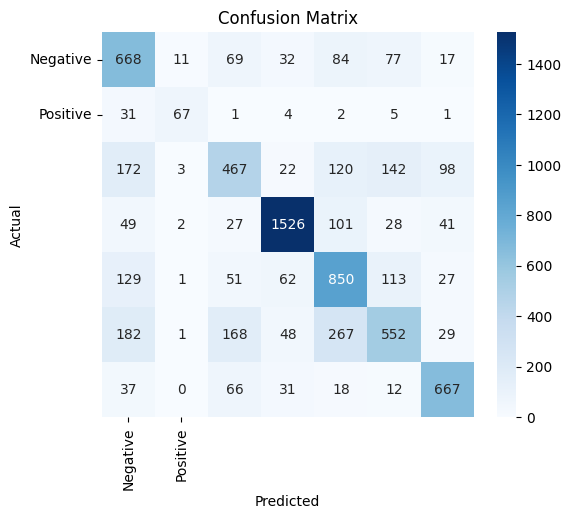

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Grad-CAM (Saliency Map)
Grad-CAM highlights the important regions in an image that influenced the model’s decision.

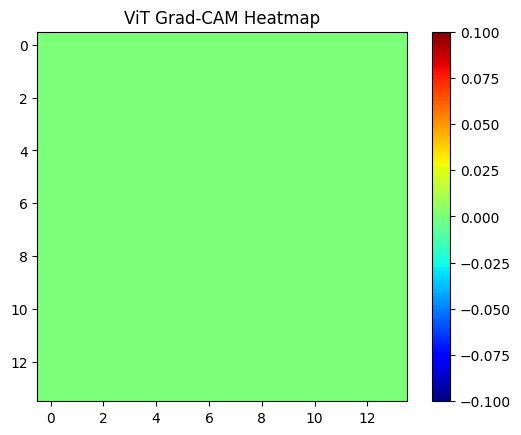

In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

def grad_cam_vit(model, image, class_index=None):

    model.eval()

    #Ensure image is a tensor with batch dimension
    if isinstance(image, torch.Tensor):
        image = image.unsqueeze(0).to(device)  # Ensure batch dimension
    else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        image = transform(image).unsqueeze(0).to(device)

    image.requires_grad = True  # Enable gradient tracking

    #Capture attention maps from the last transformer block
    features = None
    gradients = None

    def hook_fn(module, input, output):
        nonlocal features
        features = output[:, 1:, :]  # Skip class token, keep only image patches

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0][:, 1:, :]  # Skip class token

    # Select last attention block
    target_layer = model.blocks[-1].attn  # Adjust based on your architecture

    #Register hooks
    forward_handle = target_layer.register_forward_hook(hook_fn)
    backward_handle = target_layer.register_full_backward_hook(backward_hook)

    #Forward pass
    output = model(image)
    if class_index is None:
        class_index = output.argmax(dim=1).item()  # Predicted class if none provided

    #Compute gradients for the target class
    model.zero_grad()
    output[:, class_index].backward()

    #Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    #Compute Grad-CAM heatmap for ViT
    weights = torch.mean(gradients, dim=2, keepdim=True)  # Global average pooling
    cam = (weights * features).sum(dim=2)  #Multiply attention weights with activations
    cam = F.relu(cam)  #Apply ReLU to remove negative values
    cam = cam.squeeze().cpu().detach().numpy()

    #Reshape 1D heatmap to 2D (ViT processes images as patches)
    num_patches = int(np.sqrt(cam.shape[0]))  # Find patch grid size (e.g. 14x14 or 16x16)
    cam = cam.reshape(num_patches, num_patches)  # Reshape to 2D heatmap

    # Normalize heatmap
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)  #Avoid division by zero
    return cam

#Usage
image, _ = test_dataset[1]  #Get an example image from the test set (already a tensor)
heatmap = grad_cam_vit(model, image)

#Plot Heatmap
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.title("ViT Grad-CAM Heatmap")
plt.show()


# Load the correct model for the RETFound checkpoint

In [22]:
import torch
import timm
import torch.nn as nn

#Load checkpoint
checkpoint = torch.load("best_model.pth", map_location="cpu")
weights = checkpoint["model"] if "model" in checkpoint else checkpoint

#Identify model architecture from hidden size (1024 to ViT-Large)
hidden_size = weights["cls_token"].shape[-1]
model_name = "vit_large_patch16_224" if hidden_size == 1024 else "vit_base_patch16_224"

#Create model
model = timm.create_model(model_name, pretrained=False)
model.head = nn.Linear(model.head.in_features, 7)  #7 classes

#Load weights with loose matching
model.load_state_dict({k.replace("module.", ""): v for k, v in weights.items()}, strict=False)
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")
print(f" Loaded RETFound model: {model_name}")


C:\Users\samee\AppData\Local\Temp\ipykernel_33616\4080882598.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map_location="cpu"

 Loaded RETFound model: vit_large_patch16_224


# Use Captum Instead of SHAP (SHAP isn’t ideal for ViTs)

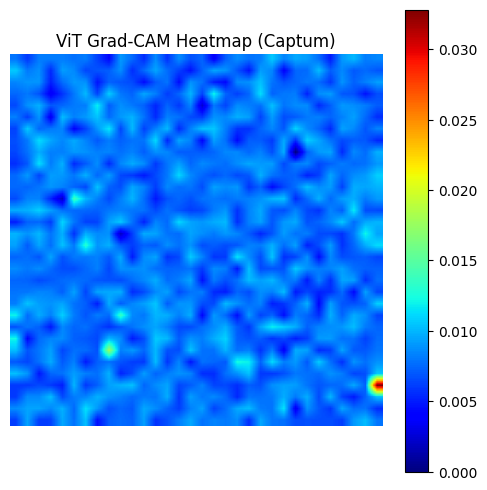

In [23]:
#Install Captum if not already installed
!pip install -q captum

#Imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import LayerGradCam, LayerAttribution

#Get device from model
device = next(model.parameters()).device

#Get a sample image from the dataset
image_tensor, label = test_dataset[7]
input_tensor = image_tensor.unsqueeze(0).to(device)

#Target the last attention block in ViT
target_layer = model.blocks[-1].attn

#Apply Grad-CAM
gradcam = LayerGradCam(model, target_layer)
attribution = gradcam.attribute(input_tensor, target=label)  # shape: [1, 1, N] or [1, N]

#Flatten if needed
attribution = attribution.view(attribution.shape[0], -1)  # shape: [1, N]

#Determine grid size
num_patches = attribution.shape[1]
side_length = int(np.sqrt(num_patches))

if side_length**2 != num_patches:
    raise ValueError(f"Grad-CAM patch count {num_patches} is not a perfect square.")

#Reshape to [1, 1, S, S]
cam_reshaped = attribution.view(1, 1, side_length, side_length)

#Interpolate to image size
cam_resized = F.interpolate(cam_reshaped, size=(224, 224), mode='bilinear', align_corners=False)

#Normalize
heatmap = cam_resized.squeeze().cpu().detach().numpy()
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

#Plot
plt.figure(figsize=(6, 6))
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.title("ViT Grad-CAM Heatmap (Captum)")
plt.axis('off')
plt.show()


# Overlay Heatmap on the Retina Image

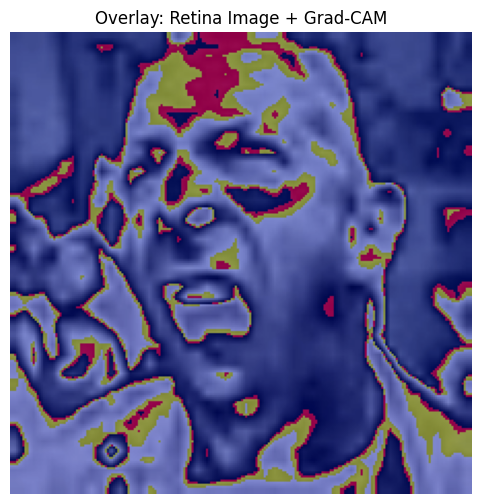

In [ ]:
!pip install opencv-python

import cv2

#Convert original image to numpy format (0-255)
original_image = image_tensor.permute(1, 2, 0).cpu().numpy()
original_image = ((original_image * 0.5 + 0.5) * 255).astype(np.uint8)  # Denormalize

#Resize heatmap to match original image size
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

#Overlay
overlayed = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(overlayed)
plt.axis('off')
plt.title("Overlay: Facial Expressions + Grad-CAM")
plt.show()
 

# Grad-CAM for Multiple Classes

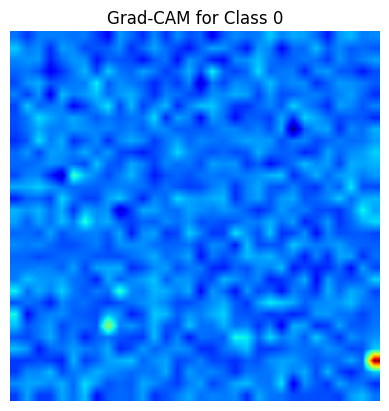

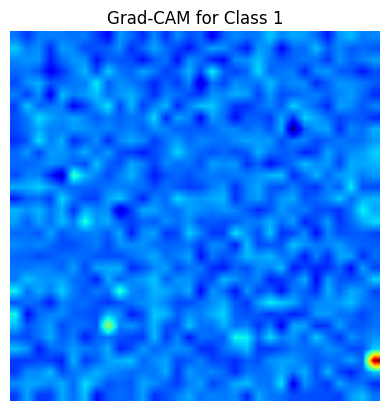

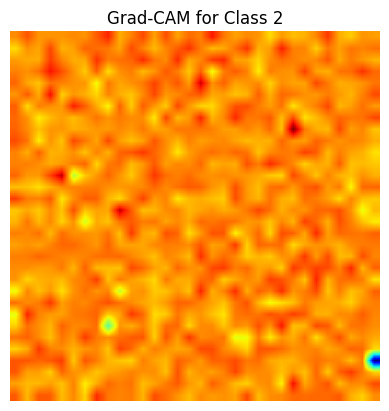

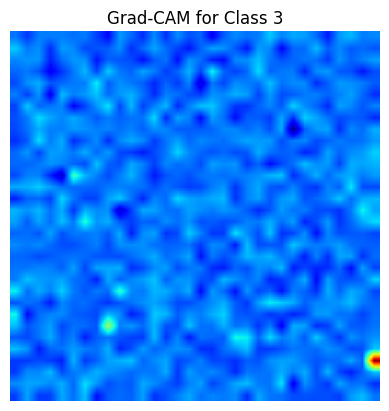

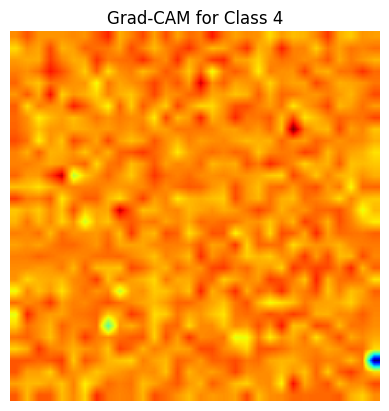

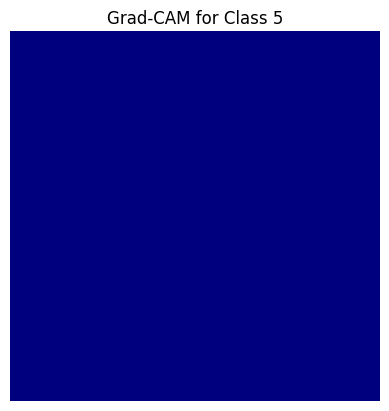

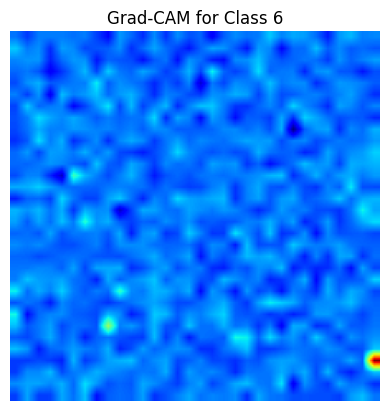

In [25]:
for class_idx in range(7):
    attribution = gradcam.attribute(input_tensor, target=class_idx)
    cam = attribution.reshape(1, 1, side_length, side_length)
    cam_resized = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
    heatmap = cam_resized.squeeze().cpu().detach().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    plt.figure()
    plt.imshow(heatmap, cmap='jet')
    plt.title(f"Grad-CAM for Class {class_idx}")
    plt.axis('off')
    plt.show()


# These explain which pixels (not just patches) most influenced a prediction. They are slower but more precise - Using Lime

In [26]:
#!pip install lime

#from lime import lime_image
#from skimage.segmentation import mark_boundaries

#explainer = lime_image.LimeImageExplainer()
#explanation = explainer.explain_instance(
    #original_image,  #shape (H, W, C)
    #classifier_fn=lambda x: model(torch.tensor(x.transpose(0, 3, 1, 2)).float().to(device)).softmax(dim=1).detach().cpu().numpy(),
    #top_labels=7,
    #hide_color=0,
    #num_samples=1000
#)

#temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 255.0, mask))
#plt.title("LIME Explanation")
#plt.axis('off')
#plt.show()


Cleaning GPU Memory

In [27]:
import gc  # Garbage collector
import torch
torch.cuda.empty_cache()
gc.collect()


41464

In [28]:
#!pip install lime

#from lime import lime_image
#from skimage.segmentation import mark_boundaries

#explainer = lime_image.LimeImageExplainer()
#explanation = explainer.explain_instance(
 #   original_image,
  #  classifier_fn=lambda x: model(torch.tensor(x.transpose(0, 3, 1, 2) / 255.0, dtype=torch.float32).to(device)).softmax(dim=1).detach().cpu().numpy(),
  #  top_labels=7,
  #  hide_color=0,
  #  num_samples=400,
  #  batch_size=16
#)


#temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 255.0, mask))
#plt.title("LIME Explanation")
#plt.axis('off')
#plt.show()


# Using fully GPU, lime image generation

  0%|          | 0/500 [00:00<?, ?it/s]

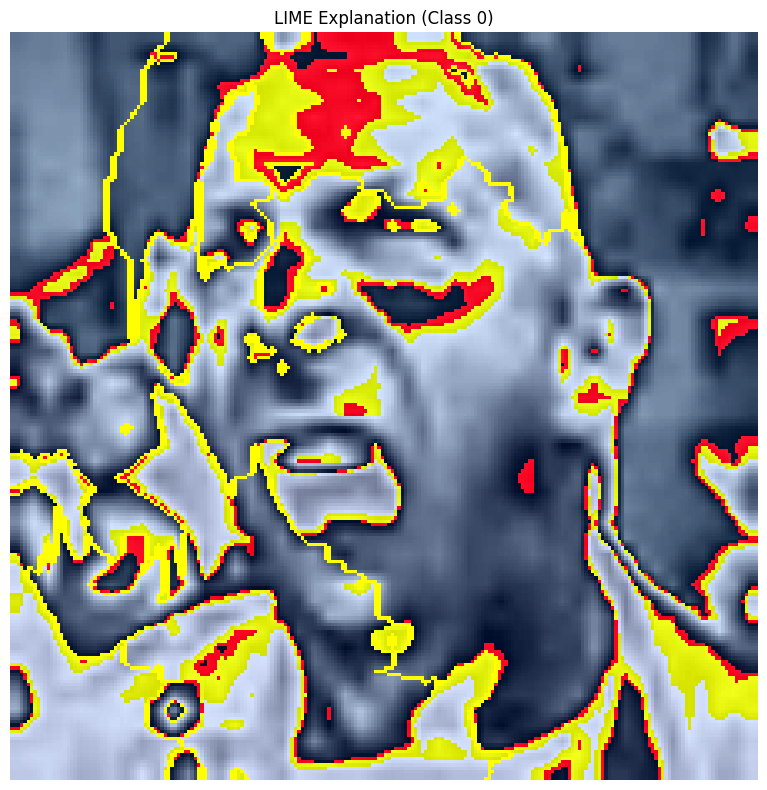

In [29]:
# 📦 Install if not already
!pip install lime scikit-image opencv-python

# 📚 Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import cv2

# ⚙️ Ensure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

# 🖼️ Load sample image
image_tensor, label = test_dataset[7]
original_image = image_tensor.permute(1, 2, 0).cpu().numpy()  # shape: (H, W, C)
original_image = ((original_image * 0.5 + 0.5) * 255).astype(np.uint8)  # Denormalize to [0, 255]

# ✅ Define LIME-compatible classifier function (batched + GPU)
def classifier_fn(images):
    with torch.no_grad():
        # images: (B, H, W, C), uint8 → float32 + normalized
        images = images.transpose(0, 3, 1, 2) / 255.0  # → (B, C, H, W)
        images = (torch.tensor(images, dtype=torch.float32).to(device) - 0.5) / 0.5  # normalize to [-1, 1]
        outputs = model(images)
        return torch.nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()

# 🧠 LIME explainer (configure with high-quality segmenter)
explainer = lime_image.LimeImageExplainer()

# 🧪 Generate explanation
explanation = explainer.explain_instance(
    image=original_image,
    classifier_fn=classifier_fn,
    top_labels=5,              # Use correct number of classes
    hide_color=0,              # Hide areas with black (neutral)
    num_samples=500,           # More samples = better explanation
    batch_size=32              # GPU-friendly batch size
)

# 🎯 Visualize explanation for the true label
temp, mask = explanation.get_image_and_mask(
    label=label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# 🎨 Overlay and visualize
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation (Class {label})")
plt.axis('off')
plt.tight_layout()
plt.show()


In [30]:
torch.save(model.state_dict(), "fine_tuned_vit.pth")
print(" Model saved successfully!")


 Model saved successfully!
